<div style="text-align: center;">
    <img src="../Streamlit/project_toto_logo.png" width="300" height="300">
</div>

# Project TOTO: Tornado Outbreak Threat Observations
ML Model: Developed by Michael Goodman

## Problem

Iowa is known for experiencing a high number of tornado events each year. These tornadoes can cause significant damage to property and pose a threat to the safety of residents. Therefore, accurately predicting tornado events in Iowa is crucial for effective disaster preparedness and response.

While advancements in meteorological technology have improved the accuracy of tornado warnings, there are still challenges in achieving a high level of precision. One of the main challenges is the occurrence of false positives, where a tornado warning is issued but no tornado actually forms. False positives can lead to unnecessary panic and disruptions in daily life, potentially causing complacency among residents when real tornado threats arise.

The goal of this project is to develop a predictive model that can effectively identify and forecast tornado events in Iowa. By leveraging historical weather data, atmospheric conditions, and other relevant factors, we aim to improve the accuracy of tornado predictions and minimize false positives. This will enable authorities to issue timely and accurate warnings, allowing residents to take appropriate safety measures and mitigate the potential impact of tornado events.

Through this project, we hope to contribute to the ongoing efforts in enhancing tornado prediction capabilities, ultimately improving the safety and resilience of Iowa communities in the face of severe weather events.

## Assumption

<div style="display: flex; justify-content: space-between;">
    <div style="flex: 1; text-align: center;">
        <img src="supercell.png" alt="Supercells are assumed primary indicator" style="max-width: 100%;">
        <p> </p>
    </div>
    <br>
    <div style="flex: 1; text-align: center;margin-left: 20px;">
        <img src="updraft.png" alt="Warm temperature can rotate a supercell" style="max-width: 100%;">
        <p> </p>
    </div>

</div>
<center>
    <p>Source: <a href="https://scijinks.gov/tornado" target="_blank">NOAA SciJinks</a></p>
</center>


- The above diagrams explain the fundemental components of a tornado formation based on scientific studies. We will attempt to use a combination of these metrics to assign a tornado formation risk
- As Iowa is mostly topagraphically consistent, the initial risk is constant across the state. This would not be the case in larger states like Illinois or Texas. 
- Wind Shear is often not a metric included in weather APIs, we will calculate our own measure by understanding the difference in magnitude of wind vectors at different altitudes. 

- From the studies, the largest risk factor associated with tornados is not the weather itself, but the change and variation in weather. We will attempt to measure this by having various rolling average signals as independent variables


## Data Engineering

#### Location Data

Location parameters were set as the centroid of Iowa Counties. Calculated using GeoPandas on an Iowa County Shape File obtained here: 
- https://geodata.iowa.gov/datasets/iowa::iowa-county-boundaries/about



Total counties: 99


C:\Users\goodm\AppData\Local\Temp\ipykernel_36544\3627250833.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid
C:\Users\goodm\AppData\Local\Temp\ipykernel_36544\3627250833.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['latitude'] = gdf.centroid.y
C:\Users\goodm\AppData\Local\Temp\ipykernel_36544\3627250833.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['longitude'] = gdf.centroid.x


Centroid data saved to Iowa_Counties_Centroid.csv


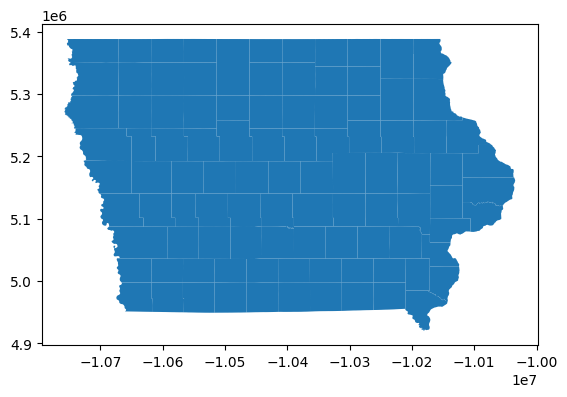

In [15]:
import geopandas as gpd

# Define the file path
shapefile_path = 'Iowa_County_Boundaries\IowaCounties.shp'

# Try reading the shapefile
try:
    gdf = gpd.read_file(shapefile_path)
    print("Total counties:", len(gdf))
    gdf.plot()
except FileNotFoundError:
    print(f"Shapefile not found at {shapefile_path}")
    exit()

# Check and convert CRS if necessary
if gdf.crs != 'epsg:4326':
    gdf = gdf.to_crs('epsg:4326')

# Calculate centroids
gdf['centroid'] = gdf.geometry.centroid
gdf['latitude'] = gdf.centroid.y
gdf['longitude'] = gdf.centroid.x

# Select relevant columns
centroid_data = gdf[['CountyName', 'latitude', 'longitude']]

# Define the output file path
output_csv_path = 'Iowa_Counties_Centroid.csv'

# Save to CSV
centroid_data.to_csv(output_csv_path, index=False)
print(f"Centroid data saved to {output_csv_path}")


Data Model sources were obtained from two sources: 
- Iowa Weather Sensor History: 
    
    https://open-meteo.com/en/docs/historical-weather-api#location_mode=csv_coordinates 

    This is a free API that allows us to request sensor information going back 6 years (5 years of training, 1 year of test).
    To avoid API throttle limits, the GUI was used with the centroid file as our list of locations

    Data Saved at: **historical_weather_ia.csv**, due to size this is in gitignore <br><br>

    
- NOAA: National Oceanic and Atmospheric Administration

    https://www.ncdc.noaa.gov/stormevents/choosedates.jsp?statefips=19%2CIOWA#

    Storm Events database to request CSV of Tornado events in Iowa, their severity, and location from 1/1/2018 through 12/31/2023


    Data Saved at: **TornadoEvents.csv**, due to size this is in gitignore



### Data Cleaning and Joining

- Event_ID needed to be created to join Tornado events and historical data
    - County-Date-Time
    - Various cleaning and standardization needed to join
    - Tornado Binary event determined if tornado happened within +-3 hours of weather record

In [32]:
import pandas as pd
import numpy as np

# Load weather data
weather_df = pd.read_csv('historical_weather_IA.csv')

# Load county centroid data and map county names to weather data
df_counties = pd.read_csv('Iowa_Counties_Centroid.csv')
weather_df['county_name'] = weather_df['location_id'].apply(lambda x: df_counties.loc[x, 'CountyName'])
weather_df['time'] = pd.to_datetime(weather_df['time'])

# Load tornado data
df_tornado = pd.read_csv('TornadoEvents.csv')
df_tornado['CZ_NAME_STR'] = df_tornado['CZ_NAME_STR'].apply(lambda x: x.title().replace(' Co.', ''))
df_tornado['BEGIN_DATETIME'] = pd.to_datetime(df_tornado['BEGIN_DATE'] + ' ' + df_tornado['BEGIN_TIME'].apply(lambda x: str(x).zfill(4)[:2] + ':' + str(x).zfill(4)[2:]))

# Initialize the tornado column to 0
weather_df['tornado'] = 0

# Iterate over tornado events and update the tornado binary within a 3-hour window and 1 hour after
for idx, tornado_event in df_tornado.iterrows():
    tornado_time = tornado_event['BEGIN_DATETIME']
    county = tornado_event['CZ_NAME_STR']
    
    time_window_start = tornado_time - pd.Timedelta(hours=3)
    time_window_end = tornado_time + pd.Timedelta(hours=1)
    
    mask = (
        (weather_df['county_name'] == county) &
        (weather_df['time'] >= time_window_start) &
        (weather_df['time'] <= time_window_end)
    )
    
    weather_df.loc[mask, 'tornado'] = 1

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
# Set display options for viewing
pd.set_option('display.max_columns', 500)
weather_df.head()

,location_id,time,temperature_2m,relative_humidity_2m,rain,pressure_msl,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,soil_temperature_0_to_7cm,county_name,tornado
0,0,2018-01-01 00:00:00,-21.2,72,0.0,1050.5,989.6,8.1,18.0,298,305,19.1,Lyon,0
1,0,2018-01-01 01:00:00,-20.7,72,0.0,1050.7,989.9,8.1,17.8,304,310,18.9,Lyon,0
2,0,2018-01-01 02:00:00,-20.2,71,0.0,1050.5,989.8,7.5,17.2,307,314,18.8,Lyon,0
3,0,2018-01-01 03:00:00,-20.0,71,0.0,1050.6,989.9,6.9,16.3,303,314,18.6,Lyon,0
4,0,2018-01-01 04:00:00,-20.2,70,0.0,1050.8,990.1,6.3,15.5,297,311,18.5,Lyon,0


In [ ]:
#export weather_df as parquet file
weather_df.to_parquet('weather_events.parquet')

### EDA

In [34]:
#read in parquet file if not already read in
import pandas as pd
weather_df = pd.read_parquet('weather_events.parquet')

In [21]:
weather_df['tornado'].value_counts()

tornado
0    5204680
1       1136
Name: count, dtype: int64

In [27]:
#ratio of tornado events to non-tornado events
print(weather_df['tornado'].mean()*100, '% of the data is tornado events')

#weight for ML model
weight = 1 / weather_df['tornado'].mean()
print('Weight for ML model:', weight.round(2))


0.021821747061363674 % of the data is tornado events
Weight for ML model: 4582.58


70.56728247914184


<Axes: ylabel='Frequency'>

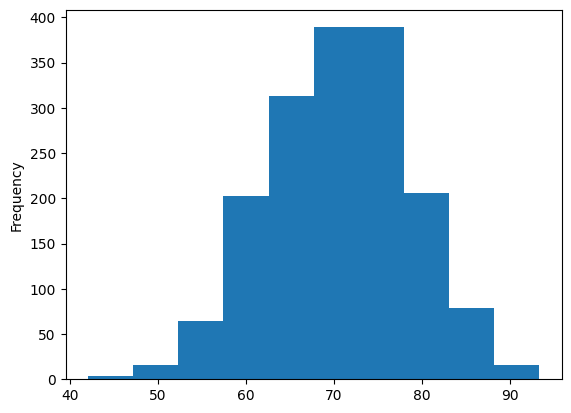

In [14]:
#show me average temperature when tornado is 1
print(weather_df[weather_df['tornado'] == 1]['temperature_2m'].mean())
#make plot of temperature when tornado is 1
weather_df[weather_df['tornado'] == 1]['temperature_2m'].plot.hist()

<Axes: ylabel='Frequency'>

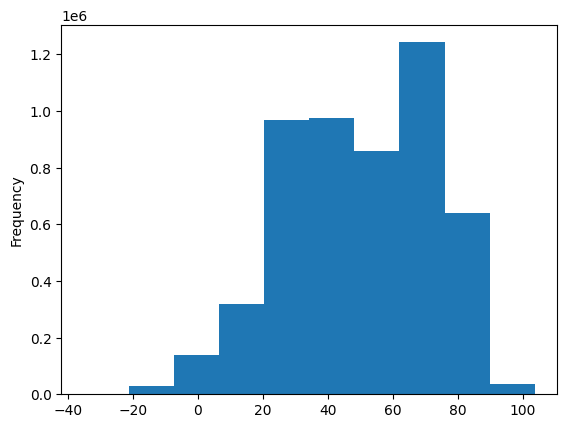

In [10]:
#plot of temperature when tornado is 0
weather_df[weather_df['tornado'] == 0]['temperature_2m'].plot.hist()

In [14]:
#pressure when tornado is 1
print(weather_df[weather_df['tornado'] == 1]['pressure_msl'].mean())

1004.0031690140846


In [15]:
#pressure when tornado is 0
print(weather_df[weather_df['tornado'] == 0]['pressure_msl'].mean())

1016.9329852747921


<Axes: ylabel='Frequency'>

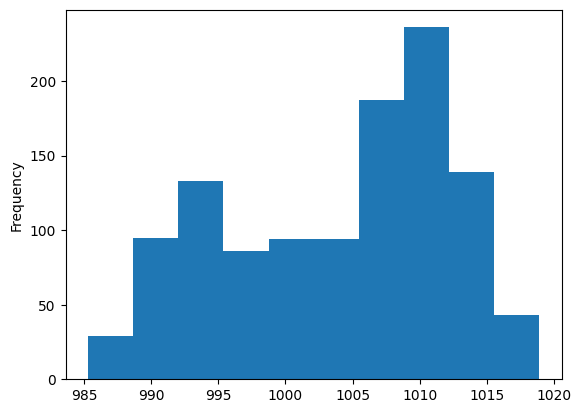

In [16]:
#histogram of pressure when tornado is 1
weather_df[weather_df['tornado'] == 1]['pressure_msl'].plot.hist()

<Axes: ylabel='Frequency'>

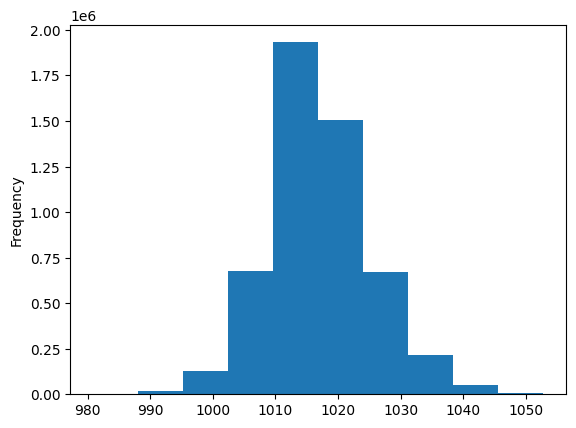

In [18]:
#hist of pressure
weather_df['pressure_msl'].plot.hist()

In [7]:
weather_df.head()

,location_id,time,temperature_2m,relative_humidity_2m,rain,pressure_msl,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,soil_temperature_0_to_7cm,county_name,tornado
0,0,2018-01-01 00:00:00,-21.2,72,0.0,1050.5,989.6,8.1,18.0,298,305,19.1,Lyon,0
1,0,2018-01-01 01:00:00,-20.7,72,0.0,1050.7,989.9,8.1,17.8,304,310,18.9,Lyon,0
2,0,2018-01-01 02:00:00,-20.2,71,0.0,1050.5,989.8,7.5,17.2,307,314,18.8,Lyon,0
3,0,2018-01-01 03:00:00,-20.0,71,0.0,1050.6,989.9,6.9,16.3,303,314,18.6,Lyon,0
4,0,2018-01-01 04:00:00,-20.2,70,0.0,1050.8,990.1,6.3,15.5,297,311,18.5,Lyon,0


### Feature Engineering

As mentioned above, a tornado is formed when thunderstorms mix with wind shear creating a supercell. As the warm front mixes with the cool air it can rotate the supercell and when it touches the ground it forms a tornado. 

The weather sensor data alone does not provide enough information to predict tornado as the differences in wind speed and direction are not captured in the data table without additional calculations  

We decided to measure the magnitude of the wind shear with vector calculations and applied signals to the data to determine the change in temperature, rain, and pressure. Many of which are factors that create a thunderstorm

<div style="display: flex; justify-content: space-between;">
    <div style="flex: 1; text-align: center;">
        <img src="shear_calc.png" alt="" style="max-width: 25%;">
        <p> </p>
    </div>

</div>
<center>
    <p>Source: <a href="https://learningweather.psu.edu/node/93" target="_blank">Penn State Department of Meteorology</a></p>
</center>

In [19]:
import numpy as np
def calculate_wind_shear(speed1, speed2, dir1, dir2):
    # Convert wind directions from degrees to radians
    dir1_rad = np.radians(dir1)
    dir2_rad = np.radians(dir2)

    # Calculate the wind vector components at the first altitude
    u1 = speed1 * np.sin(dir1_rad)
    v1 = speed1 * np.cos(dir1_rad)

    # Calculate the wind vector components at the second altitude
    u2 = speed2 * np.sin(dir2_rad)
    v2 = speed2 * np.cos(dir2_rad)

    # Calculate the wind shear components
    shear_u = u2 - u1
    shear_v = v2 - v1

    # Calculate the magnitude of the wind shear vector
    shear_magnitude = np.sqrt(shear_u**2 + shear_v**2)
    
    return shear_magnitude

In [40]:
weather_df['wind_shear'] = weather_df.apply(lambda x: calculate_wind_shear(x['wind_speed_10m'], x['wind_speed_100m'], x['wind_direction_10m'], x['wind_direction_100m']), axis=1)

<Axes: ylabel='Frequency'>

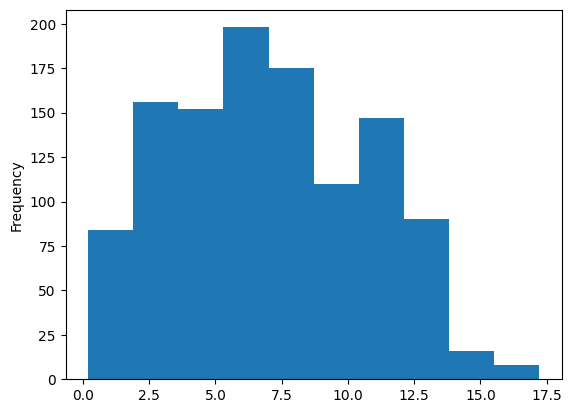

In [24]:
#histogram of wind shear when tornado is 1
weather_df[weather_df['tornado'] == 1]['wind_shear'].plot.hist()


<Axes: ylabel='Frequency'>

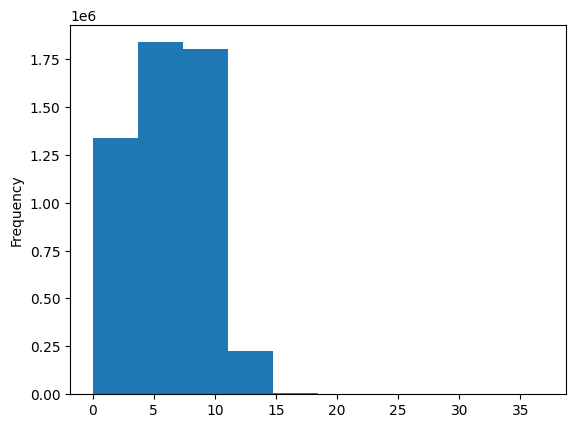

In [23]:

#histogram of wind shear when tornado is 0
weather_df[weather_df['tornado'] == 0]['wind_shear'].plot.hist()


Add location mapping and tornado class

## Model Approach

- Class Imbalance
- Split Train Test
- Initial weight

- XGboost with weight training, using f1 (explain Binary decision)
- switch to log loss
- Feature Importance initial

- Spark DF due to paralell processing
- xgboost paramater grid (explain)
- Tune and evaluate

- CatBoost Explain
- Use paper that explains why Catboost should be used
- CatBoost Parameter Grid Explain
- tune and evaluate

- Ensemble Model with Soft Voting

- Evaluate: Do false negatives relate to minor tornados? 



### Import Libraries

### Class Imbalance
Due to tornados being signifantly rare events, there is a high imbalance between our target variable. In most ML libraries, this can be addressed through a target weight parameter that is defined as Count(Negative_targets)/Count(Positive Targets)

### XGBoost
xgb was decided to be the starting point due to its benefit in highly imbalanced data. We started with the defualt learning rate and depth, and adjusted the weight parameter

Catagorical variables like location needed to be encoded first

F1 weighted was our metric used to assess performance as tornado warnings are binary

The feature importance was used to see how our intial model lined up to the domain knowledge explained above

In [ ]:
#One Hot Encode categorical variables

# Select the categorical columns
categorical_cols = []

# One-hot encode the categorical columns
weather_df = pd.get_dummies(weather_df, columns=categorical_cols)

In [ ]:
#xgboost model initial

In [ ]:
#evaluate model

In [ ]:
#feature Importance

For tuning the models, log loss could be a better metric to evaluate as it is sensitive to the imbalance and can give a more interpretable metric for meterologists to consider when issuing a warning. 

### Spark Processing

Hyperparameter tuning using GridSearch or RandomSearch is a highly computational expensive process for our dataset of over 5 million records. We utlized other libraries in pyspark to perform the tuning and model evaluation in order to benefit from paralell processing

In [ ]:
#import and init pyspark


In [ ]:
#xgboost parameter grid

In [ ]:
#xgboost spark

In [ ]:
#Evaluate best model with log loss and f1

#### CatBoost
Another model that should be considered is Catboost. According to recent research from ____. Our dataset follows a pattern that suggests catboost could be another model with positive results. The documentation from the model ___ suggests that this could be good given the emphasis on catagorical variables and the default model requiring less hyperparameter tuning

In [ ]:
#catboost grid


In [ ]:
#catboost run

In [ ]:
#catboost evaluate

#### Ensemble Model
Both models performed very well, but we want to see if performance can be increased by using an ensemble model using soft voting. 

As voting classifier in sci-kit learn does not work with spark, we created our own funciton for soft voting, which is an average of the probabilities

In [ ]:
#ensemble method in Spark

In [ ]:
#evaluate

Conclusion on best model

### Evaluate Results 

### Improvements

# Model Output

In [ ]:
#export pickle file for model
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# ScrapYard

### Initial Model

#### Basic xgboost with classification weight

In [50]:
#import train test split, standard scaler, logistic regression, classification report, confusion matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#logistic regression cv
from sklearn.linear_model import LogisticRegressionCV
#import accuracy score
from sklearn.metrics import accuracy_score


In [77]:
X = weather_df.drop(columns=['tornado', 'time','county_name', 'location_id'])
y = weather_df['tornado']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [42]:
#initial xgboost model
from xgboost import XGBClassifier
#use weight for imbalanced data
model = XGBClassifier(scale_pos_weight=weight)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#confusion matrix
confusion_matrix(y_test, y_pred)

Accuracy: 99.25%


array([[1033261,    7663],
       [     95,     145]], dtype=int64)

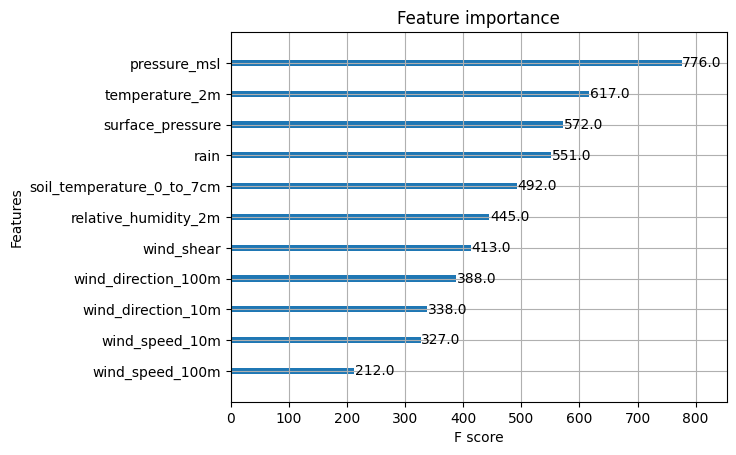

In [43]:
#feature importance
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(model)
plt.show()

#### XGBOOST with regularization

In [44]:
#xgboost with l1 regularization, #look into balancing
model = XGBClassifier(scale_pos_weight=weight, reg_alpha=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#confusion matrix
confusion_matrix(y_test, y_pred)


Accuracy: 99.29%


array([[1033587,    7337],
       [     95,     145]], dtype=int64)

#### SMOTE

In [46]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and target variable
# Example data
# X = pd.DataFrame({
#     'feature1': [...],
#     'feature2': [...],
#     # add all your features here
# })
# y = pd.Series([...])  # Your target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Calculate class weights for the original data
class_weights = dict(pd.Series(y_train).value_counts(normalize=True))
weight = class_weights[0] / class_weights[1]

# Initialize and train the XGBoost model with L1 regularization
model = XGBClassifier(scale_pos_weight=weight, reg_alpha=1)
model.fit(X_train_resampled, y_train_resampled)

# Predict on the test data
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 96.30%
Confusion Matrix:
[[1002501   38423]
 [     57     183]]


In [47]:
#SMOTE ENN
# Initialize SMOTEENN
smote_enn = SMOTEENN(random_state=42)

# Apply SMOTEENN to the training data
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Calculate class weights for the original data
class_weights = dict(pd.Series(y_train).value_counts(normalize=True))
weight = class_weights[0] / class_weights[1]

# Initialize and train the XGBoost model with L1 regularization
model = XGBClassifier(scale_pos_weight=weight, reg_alpha=1)
model.fit(X_train_resampled, y_train_resampled)

# Predict on the test data
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 78.46%
Confusion Matrix:
[[816716 224208]
 [    19    221]]


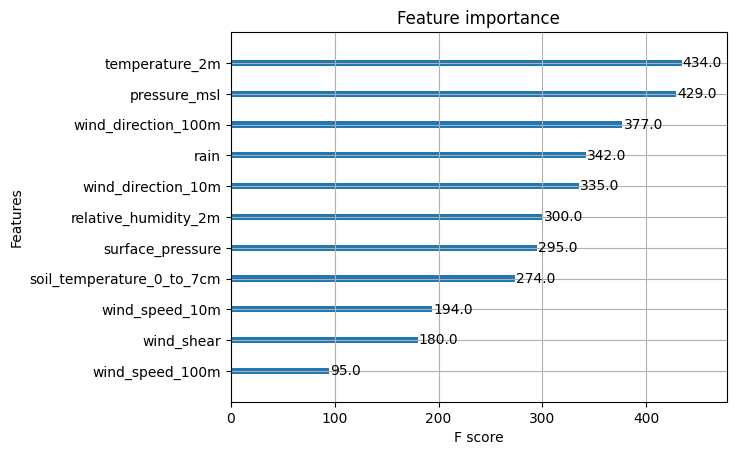

In [48]:
#feature importance
plot_importance(model)
plt.show()

#### CatBOOST

In [78]:
#catboost
from catboost import CatBoostClassifier

# Initialize and train the CatBoost model
model = CatBoostClassifier(scale_pos_weight=weight, verbose=0)
model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")


Accuracy: 99.74%
Confusion Matrix:


In [79]:
#confusion matrix from catboost
print(conf_matrix)

[[1038383    2541]
 [    129     111]]


In [58]:
#ensemble model with catboost, xgboost, cross validated
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

# Initialize the XGBoost model with L1 regularization
model1 = XGBClassifier(scale_pos_weight=weight, reg_alpha=1, n_jobs=-1)

# Initialize the CatBoost model
model2 = CatBoostClassifier(scale_pos_weight=weight, verbose=0)

# Initialize the VotingClassifier
ensemble_model = VotingClassifier(estimators=[('xgb', model1), ('catboost', model2)], voting='soft')

# Perform cross-validation
#cv_scores = cross_val_score(ensemble_model, X_train, y_train, cv=5, scoring='accuracy')

from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score, matthews_corrcoef

# Define custom scoring metrics
precision_scorer = make_scorer(precision_score)
recall_scorer = make_scorer(recall_score)
f1_scorer = make_scorer(f1_score)
roc_auc_scorer = make_scorer(roc_auc_score)
balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
mcc_scorer = make_scorer(matthews_corrcoef)

# Perform cross-validation with different scoring metrics
precision_scores = cross_val_score(ensemble_model, X_train, y_train, cv=5, scoring=precision_scorer)
recall_scores = cross_val_score(ensemble_model, X_train, y_train, cv=5, scoring=recall_scorer)
f1_scores = cross_val_score(ensemble_model, X_train, y_train, cv=5, scoring=f1_scorer)
roc_auc_scores = cross_val_score(ensemble_model, X_train, y_train, cv=5, scoring=roc_auc_scorer)
balanced_accuracy_scores = cross_val_score(ensemble_model, X_train, y_train, cv=5, scoring=balanced_accuracy_scorer)
mcc_scores = cross_val_score(ensemble_model, X_train, y_train, cv=5, scoring=mcc_scorer)

# Print the scores
print("Precision Scores: ", precision_scores)
print("Recall Scores: ", recall_scores)
print("F1 Scores: ", f1_scores)
print("ROC AUC Scores: ", roc_auc_scores)
print("Balanced Accuracy Scores: ", balanced_accuracy_scores)
print("MCC Scores: ", mcc_scores)


KeyboardInterrupt: 

In [63]:
print("Precision Scores: ", precision_scores)
print("Recall Scores: ", recall_scores)
print("F1 Scores: ", f1_scores)
print("ROC AUC Scores: ", roc_auc_scores)
print("Balanced Accuracy Scores: ", balanced_accuracy_scores)

Precision Scores:  [0.05389222 0.04695063 0.05214286 0.05064716 0.04716451]
Recall Scores:  [0.45251397 0.53888889 0.40782123 0.5027933  0.46927374]
F1 Scores:  [0.09631391 0.08637578 0.09246358 0.09202454 0.08571429]
ROC AUC Scores:  [0.72540319 0.76826222 0.70311386 0.75038374 0.73361796]
Balanced Accuracy Scores:  [0.72540319 0.76826222 0.70311386 0.75038374 0.73361796]


In [60]:
precision_scores.mean()

0.05015947487928764

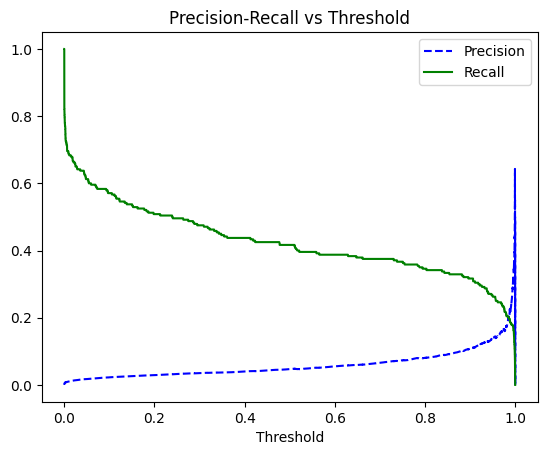

In [67]:
from sklearn.metrics import precision_recall_curve
y_prob = model.predict_proba(X_test)[:, 1]

# Get precision-recall pairs for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Plot precision-recall curve
import matplotlib.pyplot as plt

plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.title('Precision-Recall vs Threshold')
plt.show()



In [70]:
#ensemble model confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1038900    2024]
 [    140     100]]


In [62]:
#save the scores to be loaded later
import pickle

# Save the scores to a file
with open('cross_val_scores.pkl', 'wb') as f:
    pickle.dump((precision_scores, recall_scores, f1_scores, roc_auc_scores, balanced_accuracy_scores), f)

In [ ]:
# Load the scores from the file
with open('cross_val_scores.pkl', 'rb') as f:
    precision_scores, recall_scores, f1_scores, roc_auc_scores, balanced_accuracy_scores, mcc_scores = pickle.load(f)

In [72]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Define the models
model1 = XGBClassifier(scale_pos_weight=weight, reg_alpha=1, n_jobs=-1)
model2 = CatBoostClassifier(scale_pos_weight=weight, verbose=0)

# Initialize the VotingClassifier with soft voting
ensemble_model = VotingClassifier(estimators=[('xgb', model1), ('catboost', model2)], voting='soft')

# Define the parameter distributions for hyperparameter tuning
param_distributions = {
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 7],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__gamma': [0, 0.1, 0.2],
    'xgb__subsample': [0.7, 0.8, 1],
    'xgb__colsample_bytree': [0.7, 0.8, 1],
    'catboost__learning_rate': [0.01, 0.05, 0.1],
    'catboost__iterations': [100, 200, 300],
    'catboost__depth': [4, 6, 8],
    'catboost__l2_leaf_reg': [1, 3, 5],
    'catboost__border_count': [32, 50, 100],
    'catboost__bagging_temperature': [0.1, 0.5, 1],
    'catboost__rsm': [0.7, 0.8, 1]
}

# Initialize RandomizedSearchCV with the ensemble model
random_search = RandomizedSearchCV(estimator=ensemble_model, param_distributions=param_distributions, n_iter=50, cv=3, scoring='f1', n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV to the data
random_search.fit(X_train, y_train)

# Get the best estimator
best_model = random_search.best_estimator_

# Print the best parameters
print("Best Parameters: ", random_search.best_params_)

# Evaluate the best model on the test set
y_pred_best = best_model.predict(X_test)
print("Best Model Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("Best Model Classification Report:\n", classification_report(y_test, y_pred_best))


KeyboardInterrupt: 

### Parameter Tuning

### Model Selection

#### Justification

## Results and Insights

### Future Considerations

- Spatial and Time component, use LSTM
- Neural Network adjusting weights depending on results of others
- Transformers are faster now, could be used even when necesity requires as close to real time as possible

In [1]:
#export model as pickle file